# Assignment 2


In this assignment we will cover topics from the previous 3 lectures. We will cover the following topics:

1) Training a simple Linear Model

2) Implementing Modules with Backprop functionality

3) Implementing Convolution Module on Numpy.

4) Implement Dropout/Different Optimizer setups.

5) Implementing Pool and Training on CIFAR10?


It is crucial to get down to the nitty gritty of the code to implement all of these. No external packages (like caffe,pytorch etc), which directly give functions for these steps, are to be used. 

# Training a simple Linear Model

In this section, you will write the code to train a Linear Model. The goal is to classify and input $x_n$ of size $n$ into one of $m$ classes. For this goal, you need to create the following parts:

1) ** A weight Matrix $W_{n\times m}$ **, where the Weights are multipled to the input $X_n$ (Vector of size $n$), to find $m$ scores $S_m$ for the $m$ classes.

2) ** The Loss function **: We learnt two Kinds of Loss functions:
  *  The Hinge Loss: This loss measures, for each sample, how many times were the wrong classes scored above correct class score - $\Delta$ ? and by how much? This leads to the formulation:
  
$$
L_i = \sum_{j\neq y_i} \max(0, s_j - s_{y_i} + \Delta)
$$

where $y_i$ is the correct class, and $s_j$ is the score for the $j$-th class (the $j$-th element of $S_m$)
  
  * The softmax Loss: By interpreting the scores as unnormalized log probabilities for each class, this loss tries to measure dissatisfaction with the scores in terms of the log probability of the right class:

$$
L_i = -\log\left(\frac{e^{f_{y_i}}}{ \sum_j e^{f_j} }\right) \hspace{0.5in} \text{or equivalently} \hspace{0.5in} L_i = -f_{y_i} + \log\sum_j e^{f_j}
$$

where $f_{ y_i }$ is the $i$-th element of the output of $W^T_{n \times m} . X_m$

4) ** Regularization term **: In addition to the loss, you need a Regularization term to lead to a more distributed( in case of $L_2$) or sparse (in case of $L_1$) learning of the weights. For example, and having $L_2$ regularization would imply that your loss has the following additional term:

$$
R(W) = \sum_k\sum_l W_{k,l}^2,
$$

making the total loss:
$$
L =  \underbrace{ \frac{1}{N} \sum_i L_i }_\text{data loss} + \underbrace{ \lambda R(W) }_\text{regularization loss} \\\\
$$

3) ** An Optimization Procedure **: This refers to the process which tweaks the weight Matrix $W_{n\times m}$ to reduce the loss function $L$. In our case, this refers to Mini-batch Gradient Descent algorithm. We adjust the weights $W_{n\times m}$, based on the gradient of the loss $L$ w.r.t. $W_{n\times m}$. This leads to:

$$
W_{t+1} = W_{t} + \alpha \frac{\partial L}{\partial W},
$$
where $\alpha$ is the learning rate. Additionally, as we will be doing "mini-batch" gradient Descent, instead of finding loss over the whole dataset, we find it only for a small sample of the traning data for each learning step we take. Basically,
$$
W_{t+1} = W_{t} + \alpha \frac{\partial \sum^{b}{L_{x_i}}}{\partial W},
$$
where, $b$ is the batch size.

# Question 1

Train a **Single-Layer Classifier** for the MNIST dataset. Guidelines:
* Use a loss of your choice.
* Keep a validation split of the trainingset for finding the right value of $\lambda$ for the regularization, and to check for over fitting.
* Finally,evaluate the classification performance on the testset.


In [2]:
## Load The Mnist data:
# Download data from http://yann.lecun.com/exdb/mnist/
# load the data.
import os
import struct
import numpy as np
def read(dataset = "training", path = "./utils"):
    if dataset is "training":
        fname_img = os.path.join(path, 'train-images.idx3-ubyte')
        fname_lbl = os.path.join(path, 'train-labels.idx1-ubyte')
    elif dataset is "testing":
        fname_img = os.path.join(path, 't10k-images.idx3-ubyte')
        fname_lbl = os.path.join(path, 't10k-labels.idx1-ubyte')
    else:
        raise ValueError, "dataset must be 'testing' or 'training'"

    # Load everything in some numpy arrays
    with open(fname_lbl, 'rb') as flbl:
        magic, num = struct.unpack(">II", flbl.read(8))
        lbl = np.fromfile(flbl, dtype=np.int8)

    with open(fname_img, 'rb') as fimg:
        magic, num, rows, cols = struct.unpack(">IIII", fimg.read(16))
        img = np.fromfile(fimg, dtype=np.uint8).reshape(len(lbl), rows * cols)

    get_img = lambda idx: (lbl[idx], img[idx])

    # Create an iterator which returns each image in turn
    for i in xrange(len(lbl)):
        yield get_img(i)        
# split the data into train, and valid
training_data = list(read())
testing_data = list(read('testing'))
y = np.zeros(60000, dtype=np.int8)
X = np.zeros((60000,784))
for i in range(60000):
    y[i] = training_data[i][0]
    X[i] = training_data[i][1]

testLabels = np.zeros(10000, dtype=np.int8)
testData = np.zeros((10000,784))    
for i in range(10000):
    testLabels[i] = testing_data[i][0]
    testData[i]   = testing_data[i][1]
#print y[0]
#print X[0]

trainData   = X[0:48000]
trainLabels = y[0:48000]

validateData    = X[48000:]
validateLabels  = y[48000:]
# Now a function, which returns a generator random mini-batch of the input data
#print validateData[0]
def get_minibatch(training_x, training_y, batchsize):
    ## Read generator functions if required.
    ## WRITE CODE HERE
    indices = np.arange(training_x.shape[0])
    np.random.shuffle(indices)
    for start_idx in range(0, training_x.shape[0] - batchsize + 1, batchsize):
        excerpt = indices[start_idx:start_idx + batchsize]
        mini_x = training_x[excerpt]
        mini_y = training_y[excerpt]
        yield mini_x,mini_y

In [3]:
# Define the class Single Layer Classifier
class single_layer_classifier():
    
    def __init__(self, input_size, output_size):
        
        ## WRITE CODE HERE
        self.W = 0.001 * np.random.uniform(low = -10, high = 10, size=(input_size,output_size))
        self.b = np.zeros((1,output_size))
        # Give the instance a weight matrix, initialized randomly.
        
    # Define the forward function
    def forward(self, input_x):
        
        # get the scores
        scores = np.dot(input_x, self.W) + self.b
        self.input_x = input_x
        ## WRITE CODE HERE
        
        return scores
    
    # Similarly a backward function
    # we define 2 backward functions (as Loss = L1 + L2, grad(Loss) = grad(L1) + grad(L2))
    
    def backward_from_loss(self, grad_from_loss,step_size):
        
        # this function returns a matrix of the same size as the weights, 
        # where each element is the partial derivative of the loss w.r.t. the respective element of weight.
        
        ## WRITE CODE HERE
        grad_matrix = np.dot(self.input_x.T, grad_from_loss)
        self.W += -step_size * grad_matrix
        return grad_matrix
        
    def backward_from_l2(self,reg,step_size):
        
        # this function returns a matrix of the same size as the weights, 
        # where each element is the partial derivative of the regularization_term
        # w.r.t. the respective element of weight.
        
        ## WRITE CODE HERE
        grad_matrix = reg*self.W
        self.W += -step_size * grad_matrix
        return grad_matrix
    
    # BONUS
    def grad_checker(input_x, grad_matrix):
        
        # Guess what to do?
        
        ## WRITE CODE HERE
        
        if diff<threshold:
            return true
        else:
            return false

In [4]:
# Now we need the loss functions,one which calculates the loss, 
# and one which give the backward gradient
# Make any one of the suggested losses

def loss_forward(input_y,scores, batchSize):

    ## WRITE CODE HERE    
    exp_scores = np.exp(scores)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) # [N x K]
    corect_logprobs = -np.log(probs[range(batchSize),input_y])
    loss = np.sum(corect_logprobs)/batchSize
    return loss,probs
def loss_backward(input_y, probs,batchSize):
    # This part deals with the gradient from the loss to the weight matrix.
    # for example, in case of softmax loss(-log(qc)), this part gives grad(loss) w.r.t. qc

    ## WRITE CODE HERE    
    grad_from_loss = probs
    grad_from_loss[range(batchSize),input_y] -= 1
    grad_from_loss /= batchSize
    return grad_from_loss
        

In [5]:
# Finally the trainer:

# let it be for t iterations:

# make an instance of single_layer_classifier,
# get the mini-batch yielder.

    ## Write code here for each iteration of training.

In [6]:
# Find the performance on the validation set.
# find the top-1 accuracy on the validation set.

In [9]:
# now make a trainer function based on the above code, which trains for 't' iteration,
# and returns the performance on the validation

def trainer(iterations):

    ## WRITE CODE HERE
    batchSize = 200
    layer = single_layer_classifier(784,10)
    step_size = 1e-5
    reg = 1e-9
    for i in range(iterations):
        loss = 0
        for batch in get_minibatch(validateData, validateLabels, batchSize):
            input_x, input_y = batch
            scores = layer.forward(input_x)
            #print scores
            #print input_y
            loss_batch, probs = loss_forward(input_y, scores, batchSize)
            grad_from_loss = loss_backward(input_y, probs, batchSize)
            layer.backward_from_loss(grad_from_loss,step_size)
            layer.backward_from_l2(reg,step_size)
            loss += loss_batch
        if i % 20 == 0:
            scores = layer.forward(validateData)
            loss_batch, probs = loss_forward(validateLabels, scores, 12000)
            top_1 =  np.argmax(probs, axis=1)
            print "Iteration", i
            print "Loss",loss
            print "Top 1", np.sum(top_1 == validateLabels)/120.0, "%"
    return

trainer(500)

Iteration 0
Loss 323.686911043
Top 1 84.7 %
Iteration 20
Loss 35.02225711
Top 1 93.2916666667 %
Iteration 40
Loss 28.9119940056
Top 1 91.7333333333 %
Iteration 60
Loss 34.9205847721
Top 1 93.6666666667 %
Iteration 80
Loss 28.6547652532
Top 1 80.6583333333 %
Iteration 100
Loss 19.7183421891
Top 1 96.95 %
Iteration 120
Loss 11.0435160174
Top 1 95.8416666667 %
Iteration 140
Loss 13.4186178354
Top 1 97.4083333333 %
Iteration 160
Loss 19.6723488723
Top 1 86.6166666667 %
Iteration 180
Loss 16.1264044142
Top 1 96.925 %
Iteration 200
Loss 21.1523091628
Top 1 94.7666666667 %
Iteration 220
Loss 15.2541236978
Top 1 98.2 %
Iteration 240
Loss 7.83642340437
Top 1 88.8 %
Iteration 260
Loss 10.192418465
Top 1 97.5083333333 %
Iteration 280
Loss 8.6237506465
Top 1 95.025 %
Iteration 300
Loss 4.86252152243
Top 1 97.9666666667 %
Iteration 320
Loss 5.1828262974
Top 1 98.1666666667 %
Iteration 340
Loss 5.49902271078
Top 1 97.2416666667 %
Iteration 360
Loss 4.04349102688
Top 1 99.175 %
Iteration 380
Loss 4.8

In [ ]:
# Find the optimal lambda and iterations t

In [16]:
# Train on whole dataset with these values,(from scratch)
# report final performance on mnist test set.
def trainer_full(iterations):

    ## WRITE CODE HERE
    batchSize = 200
    layer1 = single_layer_classifier(784,10)
    step_size = 1e-5
    reg = 1e-9
    for i in range(iterations):
        loss = 0
        for batch in get_minibatch(trainData, trainLabels, batchSize):
            input_x, input_y = batch
            scores = layer1.forward(input_x)
            #print scores
            #print input_y
            loss_batch, probs = loss_forward(input_y, scores, batchSize)
            grad_from_loss = loss_backward(input_y, probs, batchSize)
            layer1.backward_from_loss(grad_from_loss,step_size)
            layer1.backward_from_l2(reg,step_size)
            loss += loss_batch
        if i % 20 == 0:
            print "Iteration", i
            print "Loss",loss
        
    scores = layer1.forward(testData)
    loss_batch, probs = loss_forward(testLabels, scores, 10000)
    top_1 =  np.argmax(probs, axis=1)
    print "Loss",loss_batch
    print "Top 1", np.sum(top_1 == testLabels)/100.0, "%"
    return np.sum(top_1 == testLabels)/100.0
# Find the best performing class and the worst performing class.
trainer_full(1000)


Iteration 0
Loss 710.619958537
Iteration 20
Loss 105.31568205
Iteration 40
Loss 82.8718723536
Iteration 60
Loss 73.5155045503
Iteration 80
Loss 68.6538625002
Iteration 100
Loss 65.534451617
Iteration 120
Loss 63.5065728144
Iteration 140
Loss 62.1933742776
Iteration 160
Loss 60.8696449617
Iteration 180
Loss 60.0235696543
Iteration 200
Loss 59.2504017543
Iteration 220
Loss 58.5519677215
Iteration 240
Loss 58.1999321932
Iteration 260
Loss 57.8713045942
Iteration 280
Loss 57.4431016045
Iteration 300
Loss 57.1333962144
Iteration 320
Loss 56.9089483652
Iteration 340
Loss 56.5949270949
Iteration 360
Loss 56.2671547709
Iteration 380
Loss 56.1846896667
Iteration 400
Loss 55.8321251528
Iteration 420
Loss 55.8449561017
Iteration 440
Loss 55.7822668696
Iteration 460
Loss 55.4536147013
Iteration 480
Loss 55.3678106902
Iteration 500
Loss 55.2245207399
Iteration 520
Loss 55.3247457518
Iteration 540
Loss 55.002933079
Iteration 560
Loss 55.0915953379
Iteration 580
Loss 54.8349397128
Iteration 600
Loss 

91.879999999999995

# Implementing Backprop

Now that you have had some experience with single layer networks, its time to go to more complex architectures. But first we need to completely understand and implement backpropagation.

## Backpropagation:

Simple put, a way of computing gradients of expressions through recursive application of chain rule. If,
$$
L = f (g (h (\textbf{x})))
$$
then,
$$
\frac{\partial L}{\partial \textbf{x}} = \frac{\partial f}{\partial g} \times \frac{\partial g}{\partial h} \times\frac{\partial h}{\partial \textbf{x}} 
$$

** Look into the class Lecture for more detail **



# Question 2 : Scalar Backpropagation

Evaluate the gradient of the following functions w.r.t. the input.

1) $$ f(x,y,z) =  log(\sigma(\frac{cos(\pi \times \sigma(x))+sin(\pi \times \sigma(y/2))}{z^2}))$$
where $\sigma$ is the sigmoid function. Find gradient for the following values:
  * $(x,y,z)$ =  (1,2,3)
  * $(x,y,z)$ =  (3,2,1)
  * $(x,y,z)$ =  (12,23,31)
  * $(x,y,z)$ =  (32,21,13)

2) $$ f(x,y,z) = -tan(z) + exp(4x^2 + 3x + 10) - x^{y^z} $$
where $\exp$ is the exponential function. Find gradient for the following values:
  * $(x,y,z)$ =  (-0.1 ,2 ,-3)
  * $(x,y,z)$ =  (-3, 0.2,0.5)
  * $(x,y,z)$ =  (1.2, -2.3, 3.1)
  * $(x,y,z)$ =  (3.2, 2.1, -1.3)
      

In [24]:
# To solve this problem, construct the computational graph (will help understanding the problem)(not part of assignment)
# Write each component of the graph as a class, with forward and backward functions.
import numpy as np
import math

# for eg:
class sigmoid():
    def __init__(self):
        self.x = 0
        self.sigma = 0
    def forward(self, x):
        # save values useful for backpropagation
        self.x = x
        self.sigma = 1./(1+math.exp(-x))
        return self.sigma
    def backward(self):
        return self.sigma*(1-self.sigma)
# CAUTION: Carefully treat the input and output dimension variation. At worst, handle them with if statements.
# Similarly create the classes for various sub-parts/elements of the graph.

In [29]:

# Now write func_1_creator, 
# which constructs the graph(all operators), forward and backward functions.
class Sine:
    def forward(self,x):
        self.x = x
        return math.sin(x)
    def backward(self):
        return math.cos(self.x) 

class Cosine:
    def forward(self,x):
        self.x = x
        return math.cos(x)
    def backward(self):
        return -math.sin(self.x)

class Log:
    def forward(self,x):
        self.x = x
        return math.log(x)
    def backward(self):
        return 1/self.x
    
class func1():
    def __init__(self):
        # construct the graph here, 
        # assign the instances of function modules to self.var
        self.s1 = Sine()
        self.s2 = Cosine()
        self.s3 = Log()
        self.s4 = sigmoid()
        self.s5 = sigmoid()
        self.s6 = sigmoid()
    def forward(self, x,y,z):
        self.x = x
        self.y = y
        self.z = z
        # Using the graph element's forward functions, get the output. 
        v1 = 3.14 * self.s4.forward(x)
        v2 = 3.14 * self.s5.forward(y/2)
        v3 = self.s2.forward(v1)
        v4 = self.s1.forward(v2)
        v5 = (v3+v4)/math.pow(z,2)
        self.inter = v3+v4
        v6 = self.s6.forward(v5)
        output = self.s3.forward(v6)
        return output
    
    def backward(self):
        # Use the saved outputs of each module, and backward() function calls
        g1 = self.s4.backward() #sigmoid(x)
        g2 = 3.14*g1       #pi * sigmoid
        g3 = self.s2.backward()*g2   #Cosine
        g4 = g3*(1/math.pow(self.z,2))  #Cosine/z^2
        g5 = g4 * self.s6.backward()
        grad_x = g5 * self.s3.backward()
        
        g6 = self.s5.backward()*0.5
        g7 = 3.14 * g5
        g8 = self.s1.backward() * g7
        g9 = g8 * (1/math.pow(self.z,2))
        g10 = g9 * self.s6.backward()
        grad_y = g10 * self.s3.backward()
        
        g12 = -2*self.inter*(1/math.pow(self.z,3))
        g13 = self.s6.backward() * g12
        grad_z = g13 * self.s3.backward()
        return [grad_x,grad_y,grad_z]
f1 = func1()
print "F1 results"
f1.forward(1,2,3)
print f1.backward()
f1.forward(3,2,1)
print f1.backward()
f1.forward(12,23,31)
print f1.backward()
f1.forward(32,21,13)
print f1.backward()

print ""
class Tan:
    x = 0
    def forward(self,x):
        self.x = x
        return math.tan(x)
    def backward(self):
        return math.pow((1/math.cos(self.x)),2)


class Exp:
    x = 0
    def forward(self,x):
        self.x = x
        return math.exp(self.x)
    def backward(self):
        return math.exp(self.x)

class supportFunc1:
    x = 0
    def forward(self,x):
        self.x = x
        return 4*math.pow(x,2) + 3*x + 10
    def backward(self):
        return 8*self.x + 3

class supportFunc2:
    x = 0
    y = 0
    z = 0
    def forward(self,x,y,z):
        self.x = x
        self.y = y
        self.z = z
        return math.pow(x,math.pow(y,z))
    def backward(self):
        x = self.x
        y = self.y
        z = self.z
        gradx = math.pow(y,z) * math.pow(x,math.pow(y,z-1))
        grady = math.log(x)*math.pow(x,math.pow(y,z))*z*math.pow(y,z-1)
        gradz = math.log(math.pow(x,y))*math.pow(x,math.pow(y,z))
        return [gradx, grady, gradz]
    
    
# Similarly,
class func2():
    def __init__(self):
        # construct the graph here, 
        # assign the instances of function modules to self.var
        self.tan = Tan()
        self.exp = Exp()
        self.s1 = supportFunc1()
        self.s2 = supportFunc2()
    def forward(self,x,y,z):
        # Using the graph element's forward functions, get the output. 
        v1 = self.s1.forward(x)
        v2 = -self.tan.forward(z)
        v3 = self.exp.forward(v1)
        v4 = self.s2.forward(x,y,z)
        output = v2 + v3 - v4
        return output
    
    def backward(self):
        # Use the saved outputs of each module, and backward() function calls
        b1 = self.s1.backward()
        b2 = self.exp.backward()
        a = self.s2.backward()
        grad_x = b1*b2 - a[0]
        b3 = -self.tan.backward()
        grad_y = a[1]
        
        grad_z = b3 - a[2]
        return [grad_x,grad_y,grad_z]
    
    
f2 = func2()
print "F1 results"
f2.forward(0.1,2,3)
print f2.backward()
f2.forward(3,0.2,0.5)
print f2.backward()
f2.forward(1.2, 2.3, 3.1)
print f2.backward()
f2.forward(3.2, 2.1, 1.3)
print f2.backward()

F1 results
[-0.025555797658508482, 0.00147766303934727, -0.003160740933306748]
[-0.011905197299255082, 0.006107103488737112, 0.26868077835609616]
[-1.6188740268036097e-11, 1.322387147272451e-14, 3.35293271464416e-05]
[-1.8781485520220311e-19, 8.723855227173906e-22, 0.0004557177218747555]

F1 results
[117594.91337877141, -2.763102111592856e-07, -1.0203194708907253]
[2.0775920215883447e+25, 2.007587906556902, -1.657574652798943]
[3223381504.8336573, 36.21639166982964, -5.675238594200583]
[5.717943466907864e+27, 39.95014749046378, -65.63206595251495]


## Question 3 : Modular Vector Backpropagation

* Construct a Linear Layer module, implementing the forward and backward functions for arbitrary sizes.
* Construct a ReLU module, implementing the forward and backward functions for arbitrary sizes.
* Create a 2 layer MLP using the constructed modules.

* Modifying the functions built in Question 1 , train this two layer MLP for the same data set (MNIST).

In [8]:
# Class for Linear Layer (Refer code of pytorch/tensorflow package if required.) 
import numpy as np
import os
import struct

class LinearLayer:
	def __init__(self,W,b,reg,step_size):
		self.W = W
		self.b = b
		self.reg = reg
		self.step_size = step_size
	def forward(self,x):
		self.x = x
		#print self.W, "used"
		return np.dot(x, self.W) + self.b
	def backward(self,dPrev):
		dW = np.dot(self.x.T, dPrev)
		dW += self.reg*self.W
		#print self.W ,"old"
		self.W += -step_size * dW
		#print self.W, "new"
		db = np.sum(dPrev, axis=0, keepdims=True)
		self.b += -self.step_size * db
		#return

class Relu:
	def forward(self, x):
		self.x = x
		#print x, "xclip"
		return x.clip(0)
	def backward(self):
		inter = self.x.clip(0)
		return np.where(inter <= 0, inter, 1)

def iterate_minibatches(inputs, targets, batchsize):
    indices = np.arange(inputs.shape[0])
    np.random.shuffle(indices)
    for start_idx in range(0, inputs.shape[0] - batchsize + 1, batchsize):
        excerpt = indices[start_idx:start_idx + batchsize]
	#print inputs[excerpt], targets[excerpt], "a"
        yield inputs[excerpt], targets[excerpt]

def read(dataset = "training", path = "./utils"):
    """
    Python function for importing the MNIST data set.  It returns an iterator
    of 2-tuples with the first element being the label and the second element
    being a numpy.uint8 2D array of pixel data for the given image.
    """

    if dataset is "training":
        fname_img = os.path.join(path, 'train-images.idx3-ubyte')
        fname_lbl = os.path.join(path, 'train-labels.idx1-ubyte')
    elif dataset is "testing":
        fname_img = os.path.join(path, 't10k-images.idx3-ubyte')
        fname_lbl = os.path.join(path, 't10k-labels.idx1-ubyte')
    else:
        raise ValueError, "dataset must be 'testing' or 'training'"

    # Load everything in some numpy arrays
    with open(fname_lbl, 'rb') as flbl:
        magic, num = struct.unpack(">II", flbl.read(8))
        lbl = np.fromfile(flbl, dtype=np.int8)

    with open(fname_img, 'rb') as fimg:
        magic, num, rows, cols = struct.unpack(">IIII", fimg.read(16))
        img = np.fromfile(fimg, dtype=np.uint8).reshape(len(lbl), rows * cols)

    get_img = lambda idx: (lbl[idx], img[idx])

    # Create an iterator which returns each image in turn
    for i in xrange(len(lbl)):
        yield get_img(i)

training_data = list(read())
#print(training_data[0][1].shape)
#train = training_data[0:48000]
#train = np.asarray(training_data[0:48000])
#validate = np.asarray(training_data[48000:])
#print len(train)
#print len(validate)
#print training_data[0]
y = np.zeros(60000, dtype=np.int8)
X = np.zeros((60000,784))
for i in range(60000):
	y[i] = training_data[i][0]
	X[i] = training_data[i][1]

#print y[0]
#print X[0]

trainData   = X[0:48000]
trainLabels = y[0:48000]

validateData    = X[48000:]
validateLabels  = y[48000:]

#linear classifier
W = 0.01 * np.random.uniform(low = -10, high = 10, size=(784,10))
b = np.zeros((1,10))

step_size = 1e-9
reg = 1e-3 # regularization strength

# gradient descent loop
batchSize = 200
for i in xrange(1000):
    l1 = LinearLayer(W,b,reg,step_size)
    l2 = Relu()
    loss = 0
    for batch in iterate_minibatches(validateData, validateLabels, batchSize):

        currData, currLabels = batch
        # evaluate class scores, [N x K]
        #print currLabels.shape
        l1_out = l1.forward(currData) 
        scores = l2.forward(l1_out)
        # compute the class probabilities
        exp_scores = np.exp(scores)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) # [N x K]

        # compute the loss: average cross-entropy loss and regularization
        corect_logprobs = -np.log(probs[range(batchSize),currLabels])
        data_loss = np.sum(corect_logprobs)/batchSize
        reg_loss = 0.5*reg*np.sum(W*W)
        loss_batch = data_loss + reg_loss


        # compute the gradient on scores
        dscores = probs
        dscores[range(batchSize),currLabels] -= 1
        dscores /= batchSize

        lPrev = l2.backward()
        loss +=loss_batch
        l1.backward(lPrev)
    print "iteration %d: loss %f" % (i, loss)

iteration 0: loss 9072.706308
iteration 1: loss 8305.048797
iteration 2: loss 7567.655181
iteration 3: loss 6874.925946
iteration 4: loss 6236.005202
iteration 5: loss 5654.153268
iteration 6: loss 5134.950122
iteration 7: loss 4671.533638
iteration 8: loss 4262.276161
iteration 9: loss 3902.444666
iteration 10: loss 3586.878246
iteration 11: loss 3310.806465
iteration 12: loss 3069.476110
iteration 13: loss 2858.420836
iteration 14: loss 2670.434153
iteration 15: loss 2505.057523
iteration 16: loss 2359.028478
iteration 17: loss 2226.057779
iteration 18: loss 2108.177278
iteration 19: loss 1999.930820
iteration 20: loss 1902.067247
iteration 21: loss 1812.784710
iteration 22: loss 1731.019491
iteration 23: loss 1655.960011
iteration 24: loss 1586.529163
iteration 25: loss 1522.212117
iteration 26: loss 1462.651266
iteration 27: loss 1406.911411
iteration 28: loss 1355.267460
iteration 29: loss 1307.527510
iteration 30: loss 1262.820793
iteration 31: loss 1221.355710
iteration 32: loss

iteration 268: loss 223.355020
iteration 269: loss 222.977124
iteration 270: loss 222.609099
iteration 271: loss 222.243750
iteration 272: loss 221.879069
iteration 273: loss 221.516688
iteration 274: loss 221.161829
iteration 275: loss 220.808610
iteration 276: loss 220.466104
iteration 277: loss 220.116129
iteration 278: loss 219.772856
iteration 279: loss 219.434834
iteration 280: loss 219.094332
iteration 281: loss 218.756622
iteration 282: loss 218.420491
iteration 283: loss 218.084049
iteration 284: loss 217.754626
iteration 285: loss 217.427630
iteration 286: loss 217.101439
iteration 287: loss 216.778397
iteration 288: loss 216.460615
iteration 289: loss 216.145929
iteration 290: loss 215.831193
iteration 291: loss 215.518922
iteration 292: loss 215.210454
iteration 293: loss 214.901139
iteration 294: loss 214.592878
iteration 295: loss 214.296677
iteration 296: loss 213.996167
iteration 297: loss 213.703107
iteration 298: loss 213.411816
iteration 299: loss 213.122125
iteratio

iteration 537: loss 177.200597
iteration 538: loss 177.121137
iteration 539: loss 177.043412
iteration 540: loss 176.966663
iteration 541: loss 176.889073
iteration 542: loss 176.812803
iteration 543: loss 176.735156
iteration 544: loss 176.658499
iteration 545: loss 176.583460
iteration 546: loss 176.507697
iteration 547: loss 176.431735
iteration 548: loss 176.356390
iteration 549: loss 176.282123
iteration 550: loss 176.206544
iteration 551: loss 176.133465
iteration 552: loss 176.059674
iteration 553: loss 175.985534
iteration 554: loss 175.913520
iteration 555: loss 175.839982
iteration 556: loss 175.767949
iteration 557: loss 175.695800
iteration 558: loss 175.624155
iteration 559: loss 175.553838
iteration 560: loss 175.482400
iteration 561: loss 175.412473
iteration 562: loss 175.342073
iteration 563: loss 175.272210
iteration 564: loss 175.201219
iteration 565: loss 175.132450
iteration 566: loss 175.062481
iteration 567: loss 174.993297
iteration 568: loss 174.923916
iteratio

iteration 806: loss 163.501443
iteration 807: loss 163.470070
iteration 808: loss 163.439109
iteration 809: loss 163.407994
iteration 810: loss 163.376813
iteration 811: loss 163.346040
iteration 812: loss 163.315582
iteration 813: loss 163.285326
iteration 814: loss 163.254793
iteration 815: loss 163.224348
iteration 816: loss 163.194178
iteration 817: loss 163.163982
iteration 818: loss 163.133193
iteration 819: loss 163.103503
iteration 820: loss 163.073487
iteration 821: loss 163.044070
iteration 822: loss 163.013297
iteration 823: loss 162.983070
iteration 824: loss 162.953255
iteration 825: loss 162.924040
iteration 826: loss 162.894833
iteration 827: loss 162.865111
iteration 828: loss 162.835784
iteration 829: loss 162.806548
iteration 830: loss 162.776615
iteration 831: loss 162.747038
iteration 832: loss 162.718666
iteration 833: loss 162.689281
iteration 834: loss 162.660424
iteration 835: loss 162.631314
iteration 836: loss 162.602699
iteration 837: loss 162.573689
iteratio

In [ ]:
# Class for ReLU


In [ ]:
# Your 2 layer MLP 


In [ ]:
# Train the MLP


In [ ]:
# Validation Performance


In [ ]:
# Best Class and worst class performance.
testing_data = list(read('testing'))
testLabels = np.zeros(10000, dtype=np.int8)
testData = np.zeros((10000,784))    
for i in range(10000):
    testLabels[i] = testing_data[i][0]
    testData[i]   = testing_data[i][1]
    
def trainer(iterations):

    ## WRITE CODE HERE
    batchSize = 200
    step_size = 1e-9
    reg = 1e-3
    for i in range(iterations):
        lf1 = LinearLayer(W,b,reg,step_size)
        lf2 = Relu()
        loss = 0
        for batch in iterate_minibatches(trainData, trainLabels, batchSize):
            currData, currLabels = batch
            # evaluate class scores, [N x K]
            #print currLabels.shape
            l1_out = lf1.forward(currData) 
            scores = lf2.forward(l1_out)
            # compute the class probabilities
            exp_scores = np.exp(scores)
            probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) # [N x K]

            # compute the loss: average cross-entropy loss and regularization
            corect_logprobs = -np.log(probs[range(batchSize),currLabels])
            data_loss = np.sum(corect_logprobs)/batchSize
            reg_loss = 0.5*reg*np.sum(W*W)
            loss_batch = data_loss + reg_loss


            # compute the gradient on scores
            dscores = probs
            dscores[range(batchSize),currLabels] -= 1
            dscores /= batchSize

            lPrev = lf2.backward()
            loss +=loss_batch
            lf1.backward(lPrev)
        if i % 20 == 0:
            print (i, loss)
    l1_out = lf1.forward(testData) 
    scores = lf2.forward(l1_out)
    exp_scores = np.exp(scores)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) # [N x K]
    top_1 =  np.argmax(probs, axis=1)
    print "Loss",loss_batch
    print "Top 1", np.sum(top_1 == testLabels)/10.0, "%"
    return np.sum(top_1 == testLabels)/10.0        

trainer(1000)

(0, 562.55591642544846)
(20, 562.42629980411539)
(40, 562.30127525982004)
(60, 562.17939861073171)
(80, 562.06044639182585)
(100, 561.94354344632802)
(120, 561.83059235736414)
(140, 561.7237769750534)
(160, 561.62027748541084)
(180, 561.51973541125301)
(200, 561.42200496352666)
(220, 561.32772258014393)
(240, 561.23541589276385)
(260, 561.14375551325281)
(280, 561.05276734679273)
(300, 560.96334185788885)
(320, 560.87477230510228)
(340, 560.78699934378369)
(360, 560.70036182545255)
(380, 560.61499080577903)
(400, 560.53035546841306)
(420, 560.44655970545887)
(440, 560.3646764770715)
(460, 560.28392441042195)
(480, 560.20402318526408)
(500, 560.12654958012479)
(520, 560.05040065411026)
(540, 559.97519819931711)
(560, 559.90093985411147)
(580, 559.82790994157472)


# After the lecture on Jan 31st.

# Implementing Convolution Module on Numpy.

* This topic will require you to implement the Convolution operation using Numpy.
* You will implement <s>two</s> one methods of doing it, an intuitive <s>and an optimised</s> way.
* <s>Additional operations like dropout, batch norms.</s>
* We will use the created Module for interesting task like Blurring, Bilateral Filtering.
* Finally, we create the Backprop for this.
* <s>Train a Conv model for the same MNIST dataset. (can be a script based training, instead of having it in jupyter notebook.)</s>


## Question 4

<br>
* Implement a naive Convolution module, with basic functionalities:
  * kernel_size,padding, stride, dilation
  
* Test out the convolution layer created, by using it to do gaussian blurring on 10 random images of Cifar10 dataset

* Bonus: Bilateral filtering can also be implemented using a 2-D convolution. Try bilateral filter for the space of (X,Y,Gray). (3D space, but not 3D conv), (no speed criteria), (Hint: You have multiple filters in each conv layer.)


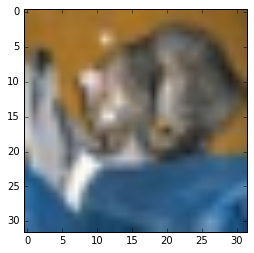

32 32 H W
(3, 32, 32)


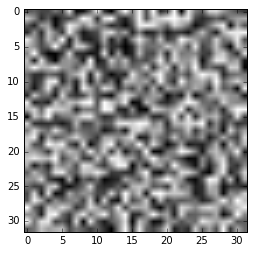

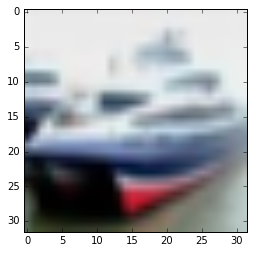

32 32 H W
(3, 32, 32)


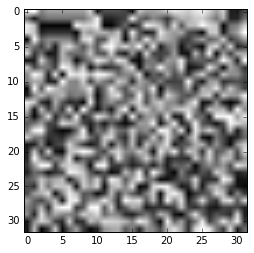

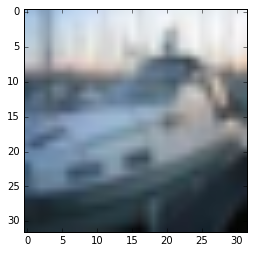

32 32 H W
(3, 32, 32)


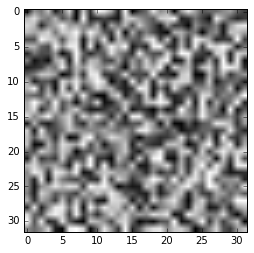

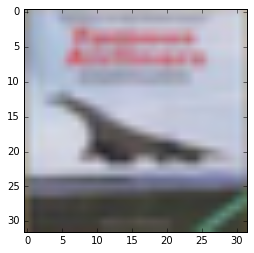

32 32 H W
(3, 32, 32)


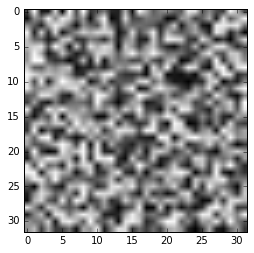

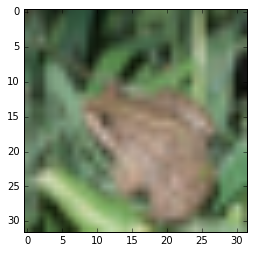

32 32 H W
(3, 32, 32)


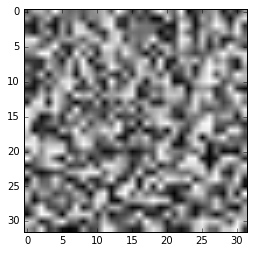

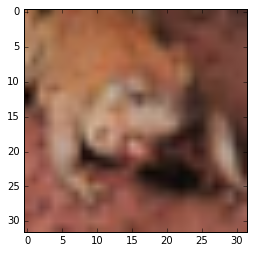

32 32 H W
(3, 32, 32)


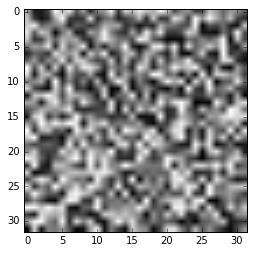

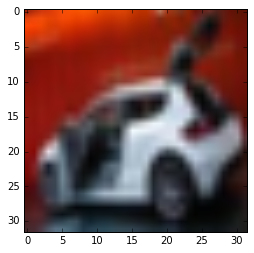

32 32 H W
(3, 32, 32)


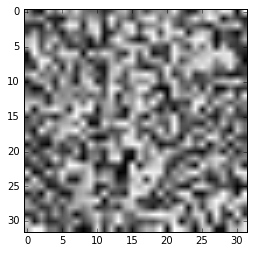

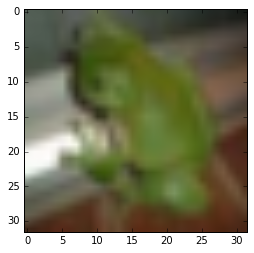

32 32 H W
(3, 32, 32)


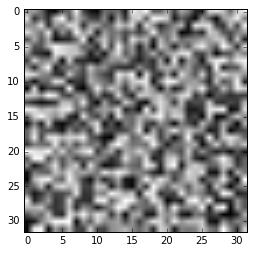

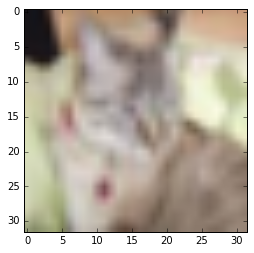

32 32 H W
(3, 32, 32)


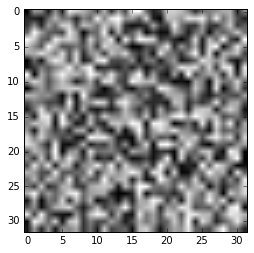

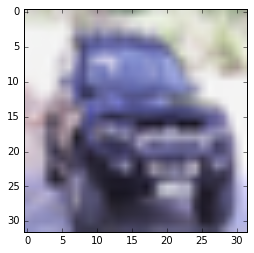

32 32 H W
(3, 32, 32)


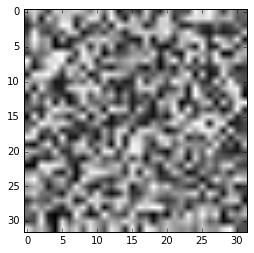

In [33]:
## Define a class Convolution Layer, which is initialized with the various required params:
import numpy as np
import cPickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def padwithzeros(vector, pad_width, iaxis, kwargs):
	vector[:pad_width[0]] = 0
	vector[-pad_width[1]:] = 0
	return vector

class convolution_layer:
    
    def __init__(self,W,H,C,K):
        ## Refer pytorch documentation/tensorflow documentation for the parameters for the layer.
        ## Bonus for implementing Groups, no-bias functionality.
        ## Random initialization of the weights
        self.W_higher = np.random.uniform(low = -10, high = 10, size=(K,C,W,H))
    def forward(self,X_higher, P, S):
        # Input Proprocess(According to pad etc.) Input will be of size (Batch_size, in_channels, inp_height, inp_width)
        
        # Reminder: Save Input for backward!
        # Simple Conv operation:
        # Loop over every location in inp_height * inp_width for the whole batch
        W_higher = self.W_higher
        (I_1, W_1, H_1) = X_higher.shape
        (J_1, K_2, F_1, F_1) = W_higher.shape
        H_2 = (H_1 - F_1 + 2*P)/S+1
        W_2 = (W_1 - F_1 + 2*P)/S+1
        print H_2, W_2, "H", "W"
        O = np.zeros((J_1,W_2, H_2))
        for j in range(J_1):
            for i in range(I_1):
                X = X_higher[i]
                W = W_higher[j,i]
                (W_1, H_1) = X.shape
                (F_1, F_1) = W.shape
                #print F_1
                X = np.lib.pad(X, P, padwithzeros)   
                for w in range(0,W_2*S,S):
		    	    for h in range(0,H_2*S,S):
		    	        x_slice = X[w:w+F_1, h:h+F_1]
		    	        O[j,w,h] += np.sum(x_slice * W) 
        return O
    
    def backward(self, grad_of_output_size):
        
        # Naive Implementation
        # Speed is not a concern
        # Hint: gradients from each independant operation can be summed
        
        #  return gradient of the size of the weight kernel
        return grad
    
    def set_weights(self, new_weights):
        self.W_higher = new_weights
        ## Replace the set of weights with the given 'new_weights'
        ## use this for setting weights for blurring, bilateral filtering etc.

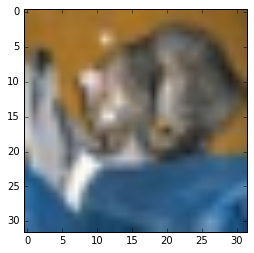

32 32 H W
(3, 32, 32)


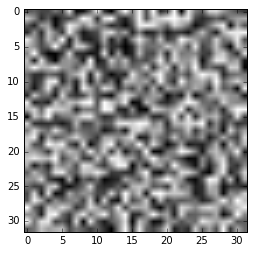

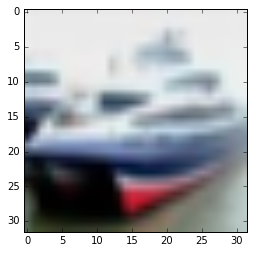

32 32 H W
(3, 32, 32)


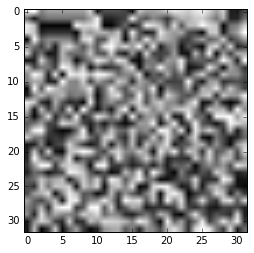

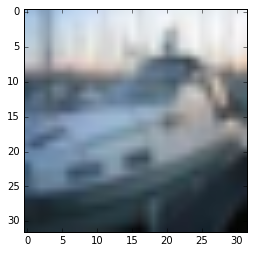

32 32 H W
(3, 32, 32)


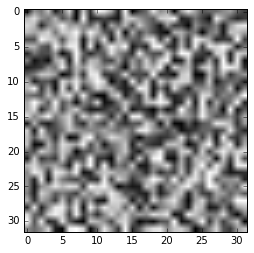

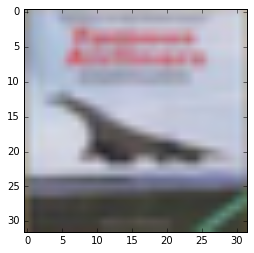

32 32 H W
(3, 32, 32)


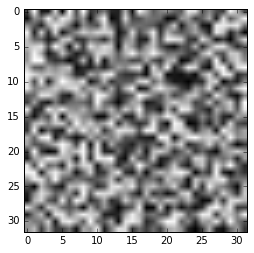

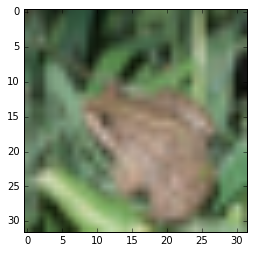

32 32 H W
(3, 32, 32)


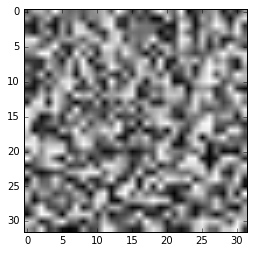

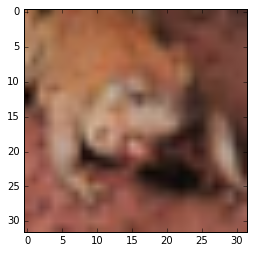

32 32 H W
(3, 32, 32)


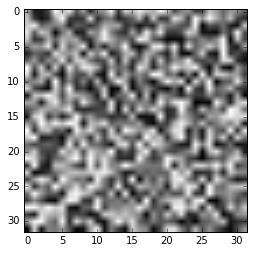

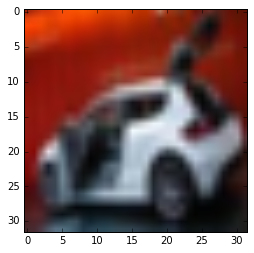

32 32 H W
(3, 32, 32)


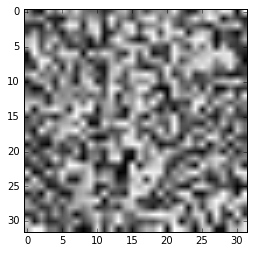

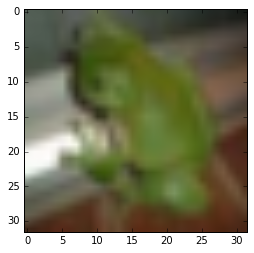

32 32 H W
(3, 32, 32)


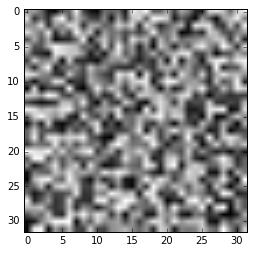

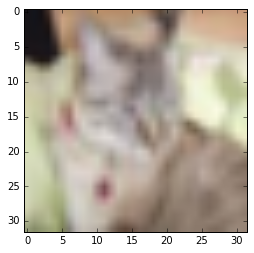

32 32 H W
(3, 32, 32)


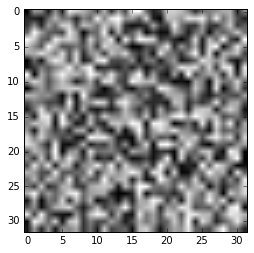

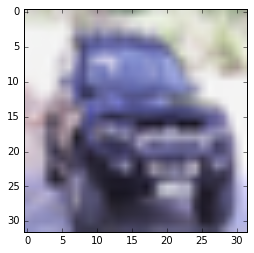

32 32 H W
(3, 32, 32)


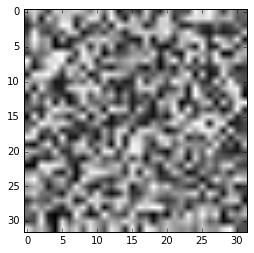

In [34]:
## get cifar images

#print type(image)
#print image.shape
'Unpickle fuction is the same one given on https://www.cs.toronto.edu/~kriz/cifar.html'
def unpickle(filetoUnpickle):
    with open(filetoUnpickle, 'rb') as fo:
        dict = cPickle.load(fo)
    return dict

filetoUnpickle = './utils/test_batch'
dict = unpickle(filetoUnpickle)
#print dict['data'][0].shape
data = dict['data'][:10,:]

	#print d
#print data.shape

## Initialize a conv layer. Set weights for gaussian blurring
gaussian = np.array([[[[1.0/48,1.0/24,1.0/48],[1.0/24,1.0/16,1.0/24],[1.0/48,1.0/24,1.0/48]],[[1.0/48,1.0/24,1.0/48],[1.0/24,1.0/16,1.0/24],[1.0/48,1.0/24,1.0/48]],[[1.0/48,1.0/24,1.0/48],[1.0/24,1.0/16,1.0/24],[1.0/48,1.0/24,1.0/48]]],[[[1.0/48,1.0/24,1.0/48],[1.0/24,1.0/16,1.0/24],[1.0/48,1.0/24,1.0/48]],[[1.0/48,1.0/24,1.0/48],[1.0/24,1.0/16,1.0/24],[1.0/48,1.0/24,1.0/48]],[[1.0/48,1.0/24,1.0/48],[1.0/24,1.0/16,1.0/24],[1.0/48,1.0/24,1.0/48]]],[[[1.0/48,1.0/24,1.0/48],[1.0/24,1.0/16,1.0/24],[1.0/48,1.0/24,1.0/48]],[[1.0/48,1.0/24,1.0/48],[1.0/24,1.0/16,1.0/24],[1.0/48,1.0/24,1.0/48]],[[1.0/48,1.0/24,1.0/48],[1.0/24,1.0/16,1.0/24],[1.0/48,1.0/24,1.0/48]]]], dtype = np.float32)
cc = convolution_layer(32,32,3,3)
cc.set_weights(gaussian)
for i in range(10):
	a = data[i]
	X = a.reshape((3,32,32))
	d = a.reshape((3,32,32)).transpose([1, 2, 0])
	#print d.shape
	plt.imshow(d)
	plt.show()
	b = cc.forward(X,1, 1)
	print b.shape
	e = b.transpose([1, 2, 0])
	plt.imshow(e)
	plt.show()    
## generate output.

## use matplotlib.pyplot to show the results.


In [ ]:
## BONUS: Bilateral Filter.


## Question 5
<br>
Now we will use the created layer for training a simple Convolution Layer. 

* The goal is to make it learn a set of weights, by using the backpropagation function created. To test the backpropagation, instead of training a whole network, we will train only a single layer.
  * Take 100 cifar10 images. Generate a numpy array of size (20,3,5,5), with samples from uniform distribution (-1,1).Initialize a Convolution layer with 20 5$\times$5 kernels(input size 3) and set the generated weights as the layer weights. Save the output of these 100 images from this Convolution layer. 
  
  * Now, initialize a new convolution layer, and use $L_2$ loss between the output of the network and the output generated in the previous step to get the same set of weights as the ones generated in the previous step.


In [ ]:
## First generate the random weight vector

## Init a conv layer with these weights

## For all images get output. Store in numpy array.



In [ ]:
# for part 2 we need to write a small L2 layer
class L2_loss():
    def ___init__():
        # empty
    
    def forward(self, inp_1,inp_2):
        # input is of dimestion(batch,channels,h,w)
        # calculate the l2 norm of inp_1 - inp_2 .,
        
        return output
    
    def backward(self,output_grad):
        # from the loss, and the input, get the grad at each location of the input.
        # The grad is of the shape (batch,channels,h,w)
        return grad

# Now Init a new conv layer and a L2 loss layer

# Train the new conv-layer using the L2 loss to get the earlier set of generated weights.
# Use batches.


# Print L2 dist between output from new convolution layer and the outputs generated initially.
